<a href="https://colab.research.google.com/github/GhosterUser31/DavidAngel/blob/main/IllusionDiffusionQW_%F0%9F%8C%80%F0%9F%A7%AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install torch torchvision diffusers transformers ipywidgets
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-av8ryrjr
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-av8ryrjr
  Resolved https://github.com/huggingface/transformers.git to commit 9613933b022ddbf085e2c593ed4ceea4c734179a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:

import torch
from diffusers import (
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    AutoencoderKL,
    StableDiffusionLatentUpscalePipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionControlNetImg2ImgPipeline,
)
from transformers import CLIPImageProcessor
from PIL import Image
import random
import os
import time

# Configuración del modelo base
BASE_MODEL = "SG161222/Realistic_Vision_V5.1_noVAE"

# Cargar modelos
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster", torch_dtype=torch.float16)

# Safety checker
SAFETY_CHECKER_ENABLED = os.environ.get("SAFETY_CHECKER", "0") == "1"
safety_checker = None
feature_extractor = None
if SAFETY_CHECKER_ENABLED:
    safety_checker = StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker").to("cuda")
    feature_extractor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Pipeline principal
main_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    vae=vae,
    safety_checker=safety_checker,
    feature_extractor=feature_extractor,
    torch_dtype=torch.float16,
).to("cuda")

# Pipeline de Img2Img
image_pipe = StableDiffusionControlNetImg2ImgPipeline(**main_pipe.components)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:

# Mapa de samplers
SAMPLER_MAP = {
    "DPM++ Karras SDE": lambda config: DPMSolverMultistepScheduler.from_config(config, use_karras=True, algorithm_type="sde-dpmsolver++"),
    "Euler": lambda config: EulerDiscreteScheduler.from_config(config),
}

# Función para recortar y redimensionar la imagen
def center_crop_resize(img, output_size=(512, 512)):
    width, height = img.size
    new_dimension = min(width, height)
    left = (width - new_dimension)/2
    top = (height - new_dimension)/2
    right = (width + new_dimension)/2
    bottom = (height + new_dimension)/2
    img = img.crop((left, top, right, bottom))
    img = img.resize(output_size)
    return img

# Función de inferencia
def inference(
    control_image: Image.Image,
    prompt: str,
    negative_prompt: str,
    guidance_scale: float = 8.0,
    controlnet_conditioning_scale: float = 1,
    seed: int = -1,
    sampler: str = "DPM++ Karras SDE"
):
    # Redimensionar imagen
    control_image_small = center_crop_resize(control_image)
    control_image_large = center_crop_resize(control_image, (1024, 1024))

    # Establecer el generador de semilla
    my_seed = random.randint(0, 2**32 - 1) if seed == -1 else seed
    generator = torch.Generator(device="cuda").manual_seed(my_seed)

    # Realizar inferencia
    main_pipe.scheduler = SAMPLER_MAP[sampler](main_pipe.scheduler.config)
    out = main_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=control_image_small,
        guidance_scale=guidance_scale,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        generator=generator,
        num_inference_steps=15,
        output_type="latent"
    )

    # Upscaling de la imagen
    upscaled_latents = upscale(out, "nearest-exact", 2)
    out_image = image_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        control_image=control_image_large,
        image=upscaled_latents,
        guidance_scale=guidance_scale,
        generator=generator,
        num_inference_steps=20,
        strength=1,
        controlnet_conditioning_scale=controlnet_conditioning_scale
    )

    return out_image["images"][0]

In [33]:

import torch
from io import BytesIO
from PIL import Image
import random
from diffusers import (
    AutoencoderKL,
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    StableDiffusionControlNetImg2ImgPipeline,
    DPMSolverMultistepScheduler,
    EulerDiscreteScheduler,
)
import os
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, HTML, Image as IPImage

# Fondo en HTML
background_html = """
<style>
body {
    background: url('https://w0.peakpx.com/wallpaper/246/10/HD-wallpaper-the-notorious-big-2020-biggie-hip-hop-rap-romania-smalls-tupac-usa.jpg') no-repeat center center fixed;
    background-size: cover;
    color: #00FF00;
}
</style>
"""
display(HTML(background_html))

BASE_MODEL = "SG161222/Realistic_Vision_V5.1_noVAE"

# Inicialización de pipelines
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster", torch_dtype=torch.float16)

main_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
).to("cuda")

image_pipe = StableDiffusionControlNetImg2ImgPipeline(**main_pipe.components)

# Map de schedulers
SAMPLER_MAP = {
    "DPM++ Karras SDE": lambda config: DPMSolverMultistepScheduler.from_config(config, use_karras=True, algorithm_type="sde-dpmsolver++"),
    "Euler": lambda config: EulerDiscreteScheduler.from_config(config),
}

def center_crop_resize(img, output_size=(512, 512)):
    width, height = img.size
    new_dimension = min(width, height)
    left = (width - new_dimension) / 2
    top = (height - new_dimension) / 2
    right = (width + new_dimension) / 2
    bottom = (height + new_dimension) / 2
    img = img.crop((left, top, right, bottom))
    img = img.resize(output_size)
    return img

def inference(
    control_image,
    prompt: str,
    resolution: int,
    negative_prompt: str = "",
    guidance_scale: float = 6.5,
    controlnet_conditioning_scale: float = 1.80,
    control_guidance_start: float = 0.0,
    control_guidance_end: float = 1.0,
    seed: int = -1,
    sampler: str = "DPM++ Karras SDE",
    num_inference_steps: int = 28,
):
    control_image = center_crop_resize(control_image, (resolution, resolution))
    main_pipe.scheduler = SAMPLER_MAP[sampler](main_pipe.scheduler.config)

    my_seed = random.randint(0, 2**32 - 1) if seed == -1 else seed
    generator = torch.Generator(device="cuda").manual_seed(my_seed)

    out = main_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=control_image,
        guidance_scale=guidance_scale,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        generator=generator,
        control_guidance_start=control_guidance_start,
        control_guidance_end=control_guidance_end,
        num_inference_steps=num_inference_steps,
    )

    return out["images"][0], my_seed

def download_image(image_path):
    files.download(image_path)

def create_gui():
    title = widgets.HTML(value="<h2 style='color: #00FF00;'>IllusionDiffusionQW - 🌀🧪</h2>")

    prompt_text = widgets.Text(value="A hell landscape hellish.", description="Prompt:")
    negative_prompt_text = widgets.Text(value="low quality, bad anatomy", description="Negative Prompt:")
    resolution_dropdown = widgets.Dropdown(
        options=[512, 768, 1024, 1256, 1500],
        value=512,
        description="Resolution:"
    )
    guidance_scale_slider = widgets.FloatSlider(value=6.5, min=0, max=20, step=0.1, description="Guidance Scale:")
    controlnet_conditioning_scale_slider = widgets.FloatSlider(value=1.80, min=0, max=2, step=0.1, description="ControlNet Scale:")
    seed_slider = widgets.IntSlider(value=42, min=0, max=100, step=1, description="Seed:")
    num_inference_steps_slider = widgets.IntSlider(value=28, min=1, max=100, step=1, description="Steps:")

    upload_button = widgets.FileUpload(accept="image/*", multiple=False)
    remove_button = widgets.Button(description="Remove Image", button_style="danger")
    generate_button = widgets.Button(description="Generate Image", button_style="success")
    download_button = widgets.Button(description="Download Image", button_style="info")
    output_area = widgets.Output()

    def on_remove_button_click(b):
        upload_button.value.clear()
        with output_area:
            output_area.clear_output()
            print("Imagen cargada eliminada.")

    def on_generate_button_click(b):
        with output_area:
            uploaded_image = upload_button.value
            if uploaded_image:
                image_data = list(uploaded_image.values())[0]["content"]
                control_image = Image.open(BytesIO(image_data))

                prompt = prompt_text.value
                negative_prompt = negative_prompt_text.value
                resolution = resolution_dropdown.value
                guidance_scale = guidance_scale_slider.value
                controlnet_conditioning_scale = controlnet_conditioning_scale_slider.value
                seed = seed_slider.value
                num_inference_steps = num_inference_steps_slider.value

                output_image, seed_used = inference(
                    control_image,
                    prompt,
                    resolution,
                    negative_prompt,
                    guidance_scale,
                    controlnet_conditioning_scale,
                    seed=seed,
                    num_inference_steps=num_inference_steps
                )
                output_image_path = "output_image.png"
                output_image.save(output_image_path)

                display(IPImage(output_image_path))
                download_button.on_click(lambda _: download_image(output_image_path))
                print(f"Imagen generada con éxito. Semilla utilizada: {seed_used}")
            else:
                print("Por favor, sube una imagen para generar la ilusión.")

    generate_button.on_click(on_generate_button_click)
    remove_button.on_click(on_remove_button_click)

    display(
        widgets.VBox([
            title,
            prompt_text,
            negative_prompt_text,
            resolution_dropdown,
            guidance_scale_slider,
            controlnet_conditioning_scale_slider,
            seed_slider,
            num_inference_steps_slider,
            widgets.HBox([upload_button, remove_button]),
            widgets.HBox([generate_button, download_button]),
            output_area
        ])
    )

create_gui()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

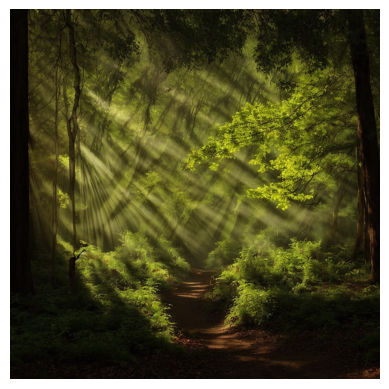

In [ ]:

import matplotlib.pyplot as plt

# Mostrar la imagen generada
plt.imshow(output_image)
plt.axis('off')  # No mostrar los ejes
plt.show()